## ASTR 597A Homework 7
Eric Bellm

Due Feb 21, 2023

Your name:
    
Your collaborators:

For this homework we'll need another external package, [sncosmo](https://sncosmo.readthedocs.io/).  Install it and then restart the kernel:

In [1]:
!pip install --user sncosmo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.5/656.5 kB 9.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.4/443.4 kB 20.2 MB/s eta 0:00:00


In [2]:
import sncosmo

## Exercise 1: Searching for Supernovae

Without using the truth table information, identify a sample of 40 or more candidate Ia supernovae.

The 07a tutorial notebook may be helpful.

#### Identify some typoe Ia supernova using peak abs mag

In [152]:
import time
from IPython.display import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service



In [7]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [8]:
redshift_min = 0.1
redshift_max = 0.3

snia_peak_mag = -19.0
snia_peak_mag_range = 0.5

In [9]:
snia_peak_mr_min = cosmo.distmod(redshift_min).value + snia_peak_mag - snia_peak_mag_range
snia_peak_mr_max = cosmo.distmod(redshift_max).value + snia_peak_mag + snia_peak_mag_range
print('The minimum and maximum apparent r-band magnitudes '
      'to use in the TAP query are %5.2f and %5.2f mag.' %
      (snia_peak_mr_min, snia_peak_mr_max))

The minimum and maximum apparent r-band magnitudes to use in the TAP query are 18.82 and 22.46 mag.


In [47]:
# Set some lc params
snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5

snia_nDiaSources_min = 30
snia_nDiaSources_max = 200

snia_duration_min = 50
snia_duration_max = 300

In [21]:
%%time

results = service.search("SELECT ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagAmp "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ",
                         maxrec=10000)

DiaObjs = results.to_table()
del results

CPU times: user 173 ms, sys: 1.79 ms, total: 175 ms
Wall time: 15.9 s


In [22]:
%%time

DiaObjs['duration'] = numpy.zeros(len(DiaObjs), dtype='float')

for j,DiaObjId in enumerate(DiaObjs['diaObjectId']):
    results = service.search("SELECT diaObjectId, midPointTai "
                             "FROM dp02_dc2_catalogs.DiaSource "
                             "WHERE diaObjectId = "+str(DiaObjId))
    results = results.to_table()
    DiaObjs['duration'][j] = numpy.max(results['midPointTai']) - numpy.min(results['midPointTai'])
    del results

CPU times: user 49 s, sys: 1.77 s, total: 50.8 s
Wall time: 11min 45s


In [48]:
tx = numpy.where((DiaObjs['duration'] > snia_duration_min)
                 & (DiaObjs['duration'] < snia_duration_max))[0]
print(len(tx))

331


In [49]:
nx = numpy.where((DiaObjs['nDiaSources'] > snia_nDiaSources_min)
                 & (DiaObjs['nDiaSources'] < snia_nDiaSources_max))[0]
print(len(nx))

2632


In [56]:
import numpy as np
tx = np.array([x for x in nx if x in tx])
len(tx)

43

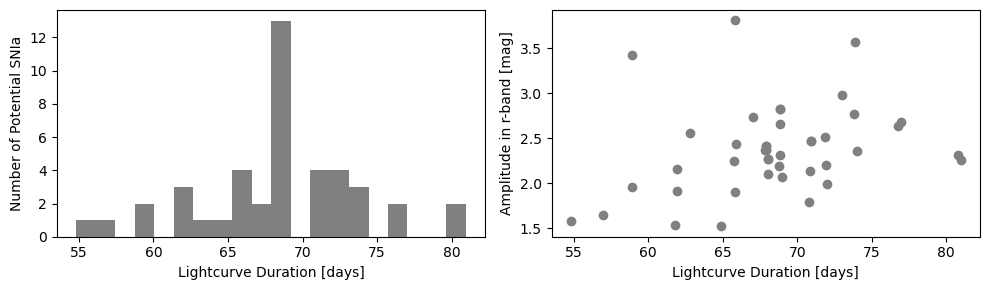

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjs['duration'][tx], bins=20, color='grey')
ax[0].set_xlabel('Lightcurve Duration [days]')
ax[0].set_ylabel('Number of Potential SNIa')

ax[1].plot(DiaObjs['duration'][tx], DiaObjs['rMagAmp'][tx], 'o', color='grey')
ax[1].set_xlabel('Lightcurve Duration [days]')
ax[1].set_ylabel('Amplitude in r-band [mag]')

plt.tight_layout()
plt.show()

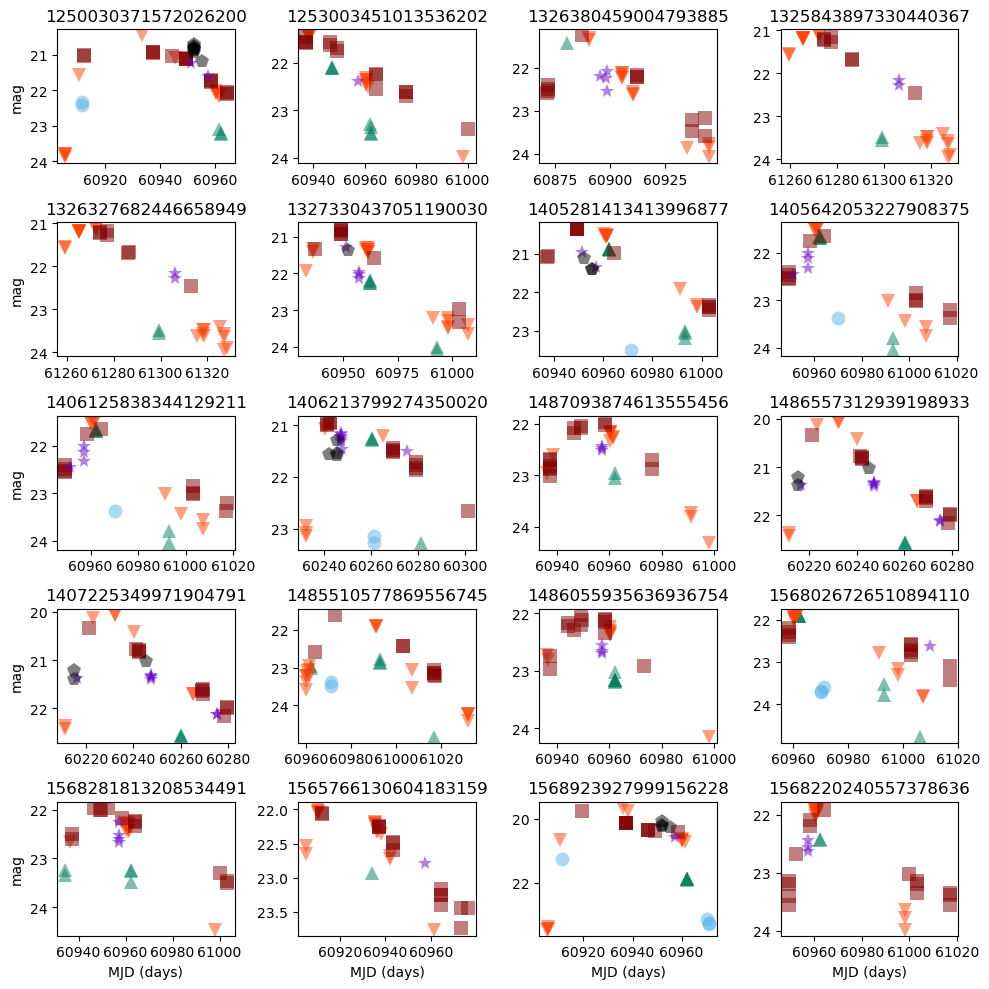

In [55]:
fig, ax = plt.subplots(5, 4, figsize=(10, 10), sharey=False, sharex=False)

x = 0

for i in range(5):
    for j in range(4):
        results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                                 "filterName, midPointTai, "
                                 "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                                 "FROM dp02_dc2_catalogs.DiaSource "
                                 "WHERE diaObjectId = "+str(DiaObjs['diaObjectId'][tx[x]]))
        results = results.to_table()

        for f, filt in enumerate(plot_filter_labels):
            fx = numpy.where(results['filterName'] == filt)[0]
            ax[i, j].plot(results['midPointTai'][fx], results['psAbMag'][fx],
                          plot_filter_symbols[filt], ms=10, mew=0, alpha=0.5,
                          color=plot_filter_colors[filt])
            del fx

        ax[i, j].invert_yaxis()
        ax[i, j].set_title(DiaObjs['diaObjectId'][tx[x]])

        if i == 4:
            ax[i, j].xaxis.set_label_text('MJD (days)')
        if j == 0:
            ax[i, j].yaxis.set_label_text('mag')

        x += 1
        del results

plt.tight_layout()
plt.show()

## Exercise 2: Ia Lightcurve fitting.

Using `sncosmo`, fit a [SALT2](https://ui.adsabs.harvard.edu/abs/2007A%26A...466...11G/abstract) model to each of the candidate Ia SNe you identified in Exercise 1.  

The fit to each lightcurve will yield parameters `z` (redshift), `t0` (time of peak brightness), `x0` (amplitude), `x1` (stretch), and `c` (color).  Save them and their errors. 

Note that the fit may fail for some of your lightcurves; that's okay.

In [66]:
for obj in df.loc[tx]['diaObjectId'][:1]:
        results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                                 "filterName, midPointTai, "
                                 "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                                 "FROM dp02_dc2_catalogs.DiaSource "
                                 "WHERE diaObjectId = "+str(DiaObjs['diaObjectId'][tx[x]]))
        results = results.to_table().to_pandas()

In [71]:
DiaObjID = obj

In [72]:
DiaObjId

1250030371572026200

In [85]:
%%time
results = service.search("SELECT fsodo.coord_ra, fsodo.coord_dec, "\
                         "fsodo.diaObjectId, fsodo.ccdVisitId, fsodo.band, "\
                         "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
                         "fsodo.psfFlux, fsodo.psfFluxErr, "\
                         "cv.expMidptMJD "\
                         "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
                         "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
                         "WHERE fsodo.diaObjectId = "+str(DiaObjID))

CPU times: user 28.3 ms, sys: 2.09 ms, total: 30.4 ms
Wall time: 1.74 s


In [86]:
FrcdSrc = results.to_table()
FrcdSrc
del results

In [87]:
%%time

results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, psFlux, psFluxErr, "
                         "filterName, midPointTai, SNR, ccdVisitId, "
                         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         "WHERE diaObjectId = "+str(DiaObjID))
DiaSrc = results.to_table()
del results

CPU times: user 9.95 ms, sys: 2.95 ms, total: 12.9 ms
Wall time: 111 ms


In [ ]:
mjd_full_start = numpy.min(FrcdSrc['expMidptMJD'])
mjd_full_end = numpy.max(FrcdSrc['expMidptMJD'])

mjd_det_start = numpy.min(DiaSrc['midPointTai'])
mjd_det_end = numpy.max(DiaSrc['midPointTai'])

In [88]:
FrcdSrc['DiffSNR'] = abs(FrcdSrc['psfDiffFlux']/FrcdSrc['psfDiffFluxErr'])

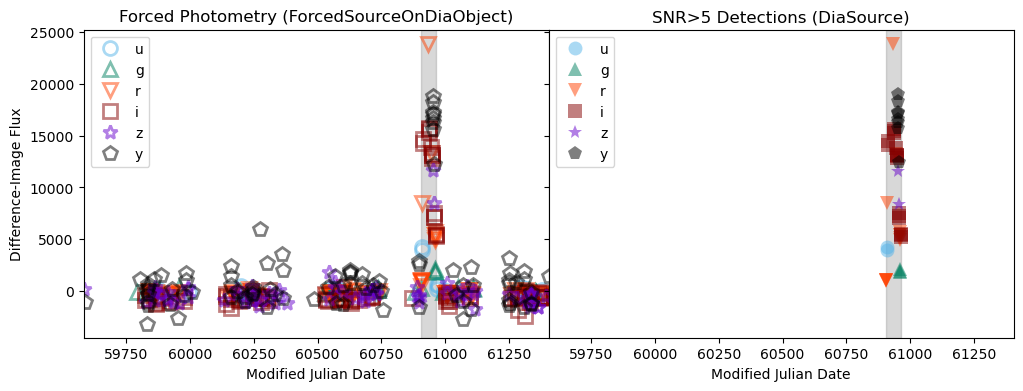

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=False)

for f, filt in enumerate(plot_filter_labels):
    fx = numpy.where(FrcdSrc['band'] == filt)[0]
    ax[0].plot(FrcdSrc['expMidptMJD'][fx], FrcdSrc['psfDiffFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=2, mec=plot_filter_colors[filt],
               alpha=0.5, color='none', label=filt)
    del fx

ax[0].set_xlabel('Modified Julian Date')
ax[0].set_ylabel('Difference-Image Flux')
ax[0].set_title('Forced Photometry (ForcedSourceOnDiaObject)')
ax[0].set_xlim(mjd_full_start, mjd_full_end)
ax[0].legend(loc='upper left')
ax[0].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')

for f, filt in enumerate(plot_filter_labels):
    fx = numpy.where(DiaSrc['filterName'] == filt)[0]
    ax[1].plot(DiaSrc['midPointTai'][fx], DiaSrc['psFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=0, color=plot_filter_colors[filt],
               alpha=0.5, label=filt)
    del fx

ax[1].set_xlabel('Modified Julian Date')
ax[1].set_title('SNR>5 Detections (DiaSource)')
ax[1].set_xlim(mjd_full_start, mjd_full_end)
ax[1].legend(loc='upper left')
ax[1].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')
plt.subplots_adjust(wspace=.0)

plt.show()

In [ ]:
d

In [158]:
def fit_params(DiaObjID):
    results = service.search("SELECT fsodo.band, "\
                             "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
                             "cv.expMidptMJD "\
                             "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
                             "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
                             "WHERE fsodo.diaObjectId = "+str(DiaObjID))


    data = results.to_table().to_pandas()

    data['band'] = ['lsst' + x for x in data['band']]
    data.columns = ['band', 'flux', 'fluxerr', 'time']

    data = data.query('flux / fluxerr > 5')
    data['zp'] = 25
    data['zpsys'] = 'ab'
    data = Table.from_pandas(data)
    model = sncosmo.Model(source='salt2')

    # run the fit
    result, fitted_model = sncosmo.fit_lc(
        data, model,
        ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
        bounds={'z':(0.3, 0.7)})  # bounds on parameters (if any)
    
    return result.parameters

In [159]:
fits = []
for obj in df.loc[tx]['diaObjectId']:
    print(obj)
    fits.append(fit_params(obj))

1250030371572026200


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1253003451013536202


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1326380459004793885


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1325843897330440367


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1326327682446658949


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1327330437051190030


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1405281413413996877


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1405642053227908375


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1406125838344129211


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1406213799274350020


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1487093874613555456


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1486557312939198933


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1407225349971904791


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1485510577869556745


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1486055935636936754


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1568026726510894110


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1568281813208534491


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1565766130604183159


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1568923927999156228


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1568220240557378636


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1570041031812976799


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1570524816929197110


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1737668176537194802


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1735460357188621288


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1821873175038791702


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1739084347513770959


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1825796232526695593


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1735777016537416922


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1911672488702513680


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1909878085725985884


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1911039170004913926


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1910924820795625873


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1653700672547196623


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1738794076444037881


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


1911496566842068570


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


2000900056319790201


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1737589011699992987


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


2092995150262308822


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


2093100703378576389


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


2092449792494933339


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


2089793372402222137


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


2093303013518086339


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'
/home/ykwang1/.local/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


1999281575203706348


/tmp/ipykernel_2847/4050759510.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zp'] = 25
/tmp/ipykernel_2847/4050759510.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['zpsys'] = 'ab'


In [160]:
fits = pd.DataFrame(fits, columns=['z', 't0', 'x0', 'x1', 'c'])

In [161]:
fits

,z,t0,x0,x1,c
0,0.528227,60928.305994,0.025745,1.373819,-0.349639
1,0.300000,60938.724840,0.012887,0.485624,-0.048205
2,0.353057,60885.454041,0.015176,0.029539,-0.177473
3,0.300000,61270.136527,0.017375,0.875391,-0.043459
4,0.300000,61270.136527,0.017375,0.875391,-0.043459
5,0.361549,60946.648011,0.026919,-1.699819,-0.325521
6,0.300000,60947.052151,0.058991,-0.722876,-0.460959
7,0.545410,60966.111033,0.009668,0.921525,-0.312120
8,0.545410,60966.111033,0.009668,0.921525,-0.312120
9,0.371405,60249.716115,0.033286,-1.492556,-0.399087


## Exercise 3: My First Hubble Diagram

Now we will use our SALT2 fit values to create a rudimentary Hubble diagram.  We will plot the distance modulus $\mu$ derived from the SALT fits as a function of redshift.

<div class="alert alert-block alert-warning">
    <b>Warning:</b> This analaysis approach is intended to be illustrative, and doesn't reflect the current state of the art for Ia cosmology.  The interested reader is encouraged to consult the literature (e.g., <a href="https://ui.adsabs.harvard.edu/abs/2022ApJ...938..111B/abstract">Brout+22</a>, <a href="https://ui.adsabs.harvard.edu/abs/2022arXiv221107657D/abstract">Dhawan+22</a>, <a href="https://ui.adsabs.harvard.edu/abs/2022ApJ...934...96S/abstract">Sanchez+22</a>, and references therein) to learn more.

</div>

The [Tripp Law](https://ui.adsabs.harvard.edu/abs/1998A%26A...331..815T/abstract) can be [written](https://ui.adsabs.harvard.edu/abs/2011ApJ...740...72M/abstract) in terms of the SALT2 model parameters:

$\mu = -2.5 \log_{10}{x_0} + \alpha x_1 - \beta c - M_0$

The parameters $\alpha$, $\beta$, and $M_0$ are typically fit along with the cosmological model.  For simplicity, we will adopt the DC2 values $\alpha = 0.137$, $\beta=3.21$ (see Table 1 of [Sanchez+22](https://ui.adsabs.harvard.edu/abs/2022ApJ...934...96S/abstract)).

### Exercise 3a:

Using the above formula, plot the distance modulus versus redshift for our Ia supernovae.  Overplot the theoretical luminosity distance vs. redshift curve for a fiducial cosmology.  Use "chi by eye" to adjust $M_0$ until the points overlap reasonably with the model.

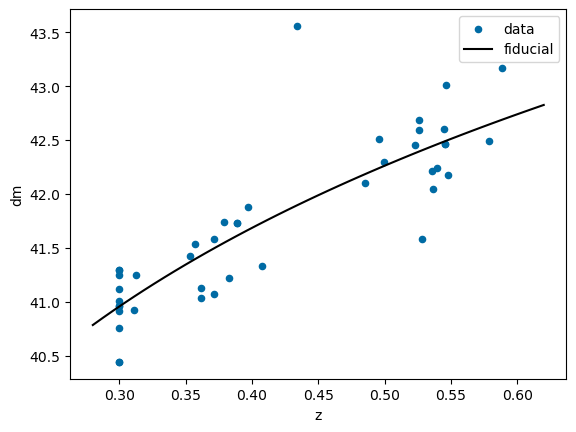

In [186]:
alpha = 0.137
beta = 3.21
M0 = -36.3

fits['dm'] = -2.5 * np.log10(fits['x0']) + alpha * fits['x1'] - beta * fits['c'] - M0

zs = np.linspace(0.28, 0.62, 45)
dms = np.array([cosmo.distmod(z).value for z in zs])

fig, ax = plt.subplots()
fits.plot.scatter(x='z', y='dm', ax=ax, label='data')
ax.plot(zs, dms, color='k', label='fiducial')
plt.legend()

## Exercise 3b:

Compute the standard deviation of the residuals between the fit $\mu$ values and the luminosity distance expected at that redshift.  How does that compare to the simulated "intrinsic scatter" of 0.15 mag in the DC2 simulations (Table 1 of [Sanchez+22](https://ui.adsabs.harvard.edu/abs/2022ApJ...934...96S/abstract))? 

What steps could you imagine taking to reduce the scatter in your Hubble diagram?  In what ways will the DC2 analysis tend to _underestimate_ the scatter that will be seen in real LSST analysis?

In [187]:
fits['fiducial'] = np.array([cosmo.distmod(z).value for z in fits['z']])

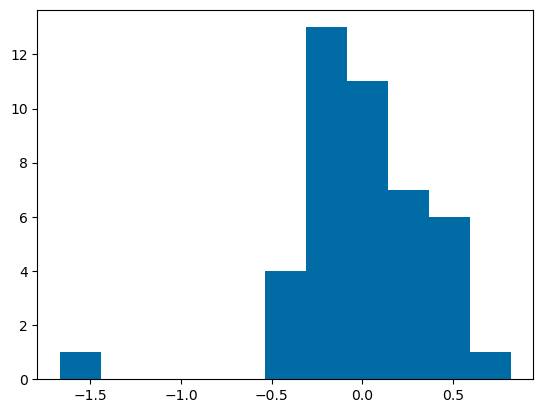

In [188]:
plt.hist(fits['fiducial'] - fits['dm'], bins='fd')
plt.show()

In [190]:
(fits['fiducial'] - fits['dm']).std()

0.3897624955343068

Since distance modulus is in the same "units" as magnitudes, the standard deviation reveals a scatter of ~0.4, which is greater than the simulated intrinsic scatter of 0.15 from DC2 sims. One major source of additional scatter is reddening from interstellar and intergalactic medium. 

## Exercise 4 (Optional): Compare to the Truth Table

Since DC2 consists of simulated data, we can see how well we recovered the input parameters.
See [this notebook](https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/desc_truth/read_truth_parquet_files.ipynb) for more details.

You might:

 * Spatially crossmatch your Ia sample to the truth table and compare your fit parameters to the true values.

 * Generate a Hubble Diagram with the truth values

 * Use the truth redshift only and re-fit the SALT2 model with the redshift constraint, mimicking the case of having a spectroscopic redshift



In [ ]:
pfnm_sn_sum = '/project/jchiang/Run2.2i/truth/SNe/truth_sn_summary_v1-0-0.parquet'

In [ ]:
%%time
result_sn_sum = pd.read_parquet(pfnm_sn_sum)
result_sn_sum.head()